<a href="https://colab.research.google.com/github/JINJA-E/rep4DL/blob/main/chapter09_part01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Advanced deep learning for computer vision

## Three essential computer vision tasks

Image Classification
* biking running swimming으로 구별(셋중하나)
* bike tree person car boat house로 구별 (다중 선택)

Image Segmentation
* 이미지를 카테고리화할 수 있는 영역으로 분할하는 것

Object detection
* bounding boxes를 그리는 것이 목표

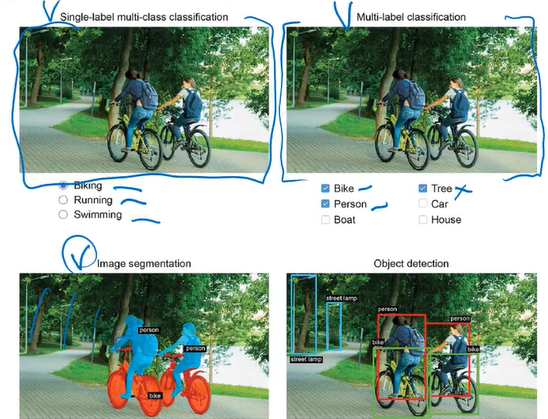

## An image segmentation example

Oxford-IIIT Pets dataset
* 7390 pictures of various breeds of cats and dogs, together with foreground-background segmentation masks
* Segmentation mask is the image-segmentation equivalent of a label

1 -> foreground

2 -> background

3 -> countour

(예시임)

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz #tar -> unzip the file
!tar -xf annotations.tar.gz

--2022-05-10 10:49:34--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2022-05-10 10:49:34--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M   110MB/s    in 7.0s    

2022-05-10 10:49:41 (108 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2022-05-10 10:49:41--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Con

In [ ]:
!ls

annotations	    annotations.tar.gz.1  images.tar.gz
annotations.tar.gz  images		  sample_data


In [ ]:
import os

fnmst = os.listdir('images')
len(fnmst)

7393

In [ ]:
os.listdir()

['.config',
 'annotations.tar.gz.1',
 'images',
 'images.tar.gz',
 'annotations.tar.gz',
 'annotations',
 'sample_data']

In [ ]:
!cat annotations/README

OXFORD-IIIT PET Dataset
-----------------------
Omkar M Parkhi, Andrea Vedaldi, Andrew Zisserman and C. V. Jawahar

We have created a 37 category pet dataset with roughly 200 images for each class. 
The images have a large variations in scale, pose and lighting. All images have an 
associated ground truth annotation of breed, head ROI, and pixel
level trimap segmentation.

Contents:
--------
trimaps/ 	Trimap annotations for every image in the dataset
		Pixel Annotations: 1: Foreground 2:Background 3: Not classified
xmls/		Head bounding box annotations in PASCAL VOC Format

list.txt	Combined list of all images in the dataset
		Each entry in the file is of following nature:
		Image CLASS-ID SPECIES BREED ID
		ID: 1:37 Class ids
		SPECIES: 1:Cat 2:Dog
		BREED ID: 1-25:Cat 1:12:Dog
		All images with 1st letter as captial are cat images while
		images with small first letter are dog images.
trainval.txt	Files describing splits used in the paper.However,
test.txt	you are encouraged to try ra

In [ ]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

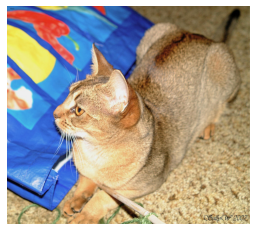

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

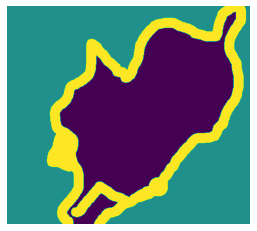

In [ ]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

In [ ]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

#(7000,200,200,3)
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32") #num_imags = 7000 img_size=200*200, 3-> channel(rgb)
#(7000,200,200,1)
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [ ]:
print(input_imgs.shape)
print(targets.shape)

(7390, 200, 200, 3)
(7390, 200, 200, 1)


In [ ]:
print(targets.min(),targets.max())

0 2


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,)) # (200,200,3)
    x = layers.Rescaling(1./255)(inputs) #values -> 0~1
    #strides, all conv2d층을 사용했다는것을 확인
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    #maxpooling대신 strides를 추가한 이유 : we are a lot about the spatial location of info
    #maxpooling destroy location info

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

UP-sampling
* motivation : need a transformation going in the opposite direction of convolutionals

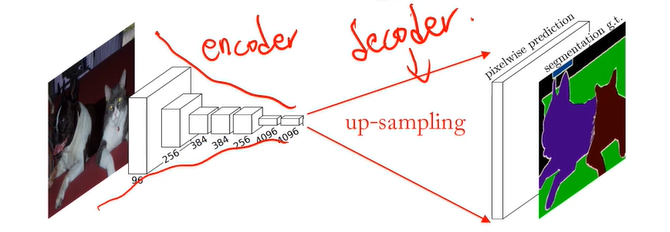

Going backward of a convolutional operations
* 3x3 convolution on 4x4 input to 2x2 output
* 3x3 transposed convolution on 2x2 input to 4x4 outputs
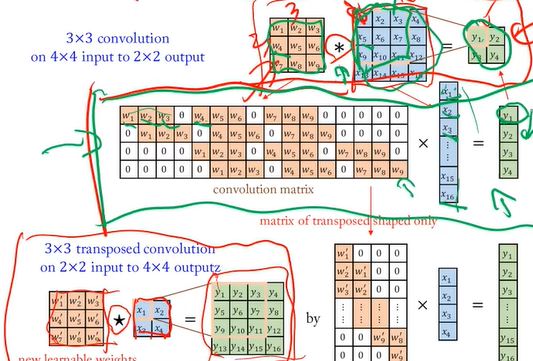![image.png]()

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
#0,1,2 중하나니까 sparse_categorical_crossentropy

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
  5/100 [>.............................] - ETA: 1:49 - loss: 2.5100

KeyboardInterrupt: ignored

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

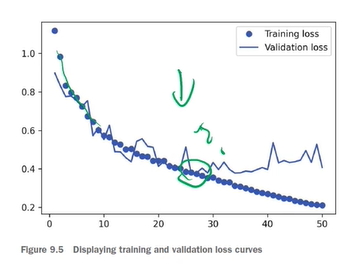

reload our best performing model according to the val_loss,

and demonstrate how to use it to predict a segmentation mask

In [ ]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)